In [ ]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sanikamal/horses-or-humans-dataset")


100%|██████████| 307M/307M [00:01<00:00, 183MB/s]

Extracting files...


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')>.97):
                print("\nReached 97 % accuracy so cancelling training!")
                self.model.stop_training = True

In [ ]:
local_zip = '/horses-or-humans.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/horses_humans_dataset/')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

In [ ]:
# Directory with our training horse pictures for training
train_horse_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/horse-or-human/train/horses')

# Directory with our training human pictures for training
train_human_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/horse-or-human/train/humans')

# Directory with our training horse pictures for validation
validation_horse_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/horse-or-human/validation/horses')

# Directory with our training human pictures for validation
validation_human_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/horse-or-human/validation//humans')

In [ ]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

validation_horse_hames = os.listdir(validation_horse_dir)
print(validation_horse_hames[:10])

validation_human_names = os.listdir(validation_human_dir)
print(validation_human_names[:10])

['horse01-1.png', 'horse07-8.png', 'horse04-2.png', 'horse02-5.png', 'horse01-6.png', 'horse02-6.png', 'horse01-3.png', 'horse02-9.png', 'horse01-0.png', 'horse06-3.png']
['human02-18.png', 'human03-16.png', 'human02-28.png', 'human01-02.png', 'human03-22.png', 'human03-13.png', 'human03-03.png', 'human03-12.png', 'human02-21.png', 'human03-05.png']
['horse3-416.png', 'horse3-255.png', 'horse2-582.png', 'horse2-112.png', 'horse4-043.png', 'horse2-183.png', 'horse1-127.png', 'horse3-011.png', 'horse3-397.png', 'horse1-122.png']
['valhuman01-17.png', 'valhuman03-11.png', 'valhuman03-20.png', 'valhuman03-23.png', 'valhuman01-16.png', 'valhuman01-03.png', 'valhuman01-07.png', 'valhuman03-06.png', 'valhuman03-03.png', 'valhuman04-09.png']


In [ ]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))
print('total validation horse images:', len(os.listdir(validation_horse_dir)))
print('total validation human images:', len(os.listdir(validation_human_dir)))

total training horse images: 500
total training human images: 527
total validation horse images: 128
total validation human images: 128


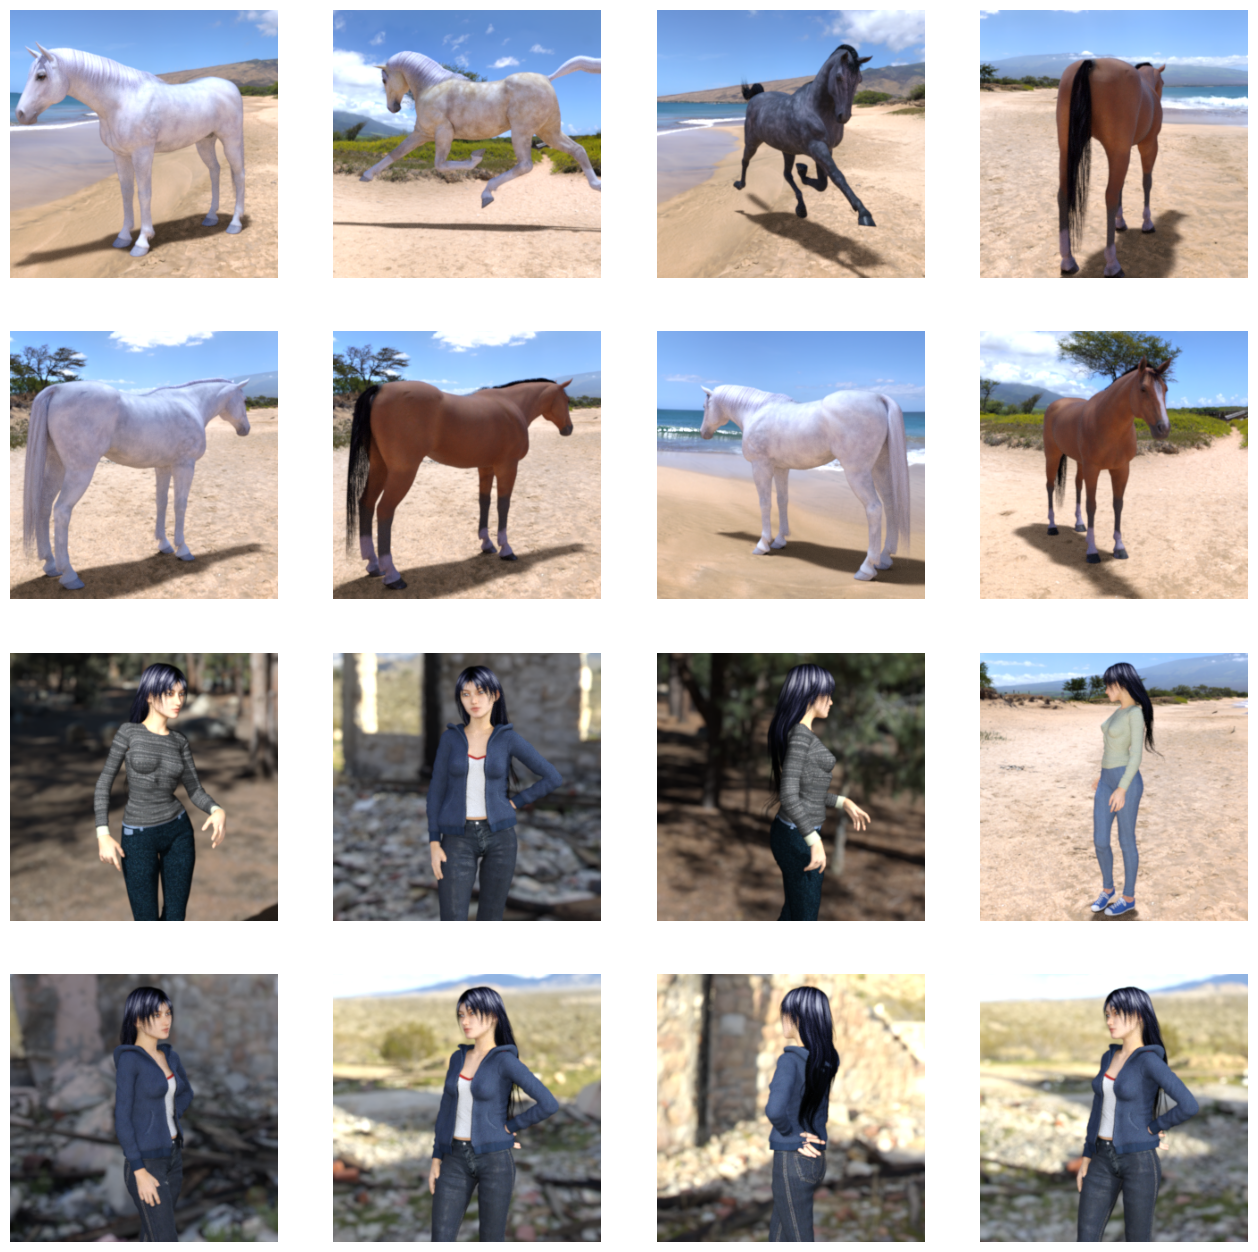

In [ ]:
import matplotlib.image as mpimg

nrows = 4
ncols = 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname)
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname)
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/horse-or-human/validation/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 2566 images belonging to 3 classes.
Found 256 images belonging to 2 classes.


In [ ]:
callbacks = myCallback()

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(300, 300, 3)), # Add Input layer
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 5, 5, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,465 (1.02 MB)

 Trainable params: 266,465 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
                loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
history=model.fit(
                    train_generator,
                    validation_data = validation_generator,
                    epochs=15,
                    callbacks=[callbacks]
                  )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 529s 24s/step - accuracy: 0.4242 - loss: 0.6703 - val_accuracy: 0.5000 - val_loss: 0.7706
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 285s 14s/step - accuracy: 0.3924 - loss: 0.6674 - val_accuracy: 0.5000 - val_loss: 0.6535
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 277s 13s/step - accuracy: 0.3934 - loss: 0.6354 - val_accuracy: 0.5000 - val_loss: 0.7736
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 292s 14s/step - accuracy: 0.4024 - loss: 0.6510 - val_accuracy: 0.5078 - val_loss: 0.6892
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 276s 13s/step - accuracy: 0.3960 - loss: 0.6296 - val_accuracy: 0.5195 - val_loss: 0.6627
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 289s 14s/step - accuracy: 0.4113 - loss: 0.6251 - val_accuracy: 0.5039 - val_loss: 1.1066
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 274s 14s/step - accuracy: 0.3853 - loss: 0.6134 - val_accuracy: 0.5000 - val_loss: 1.6660
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 333s 14s/step - accuracy: 0.3929 - loss: 0.6491 - val_accuracy: 0.

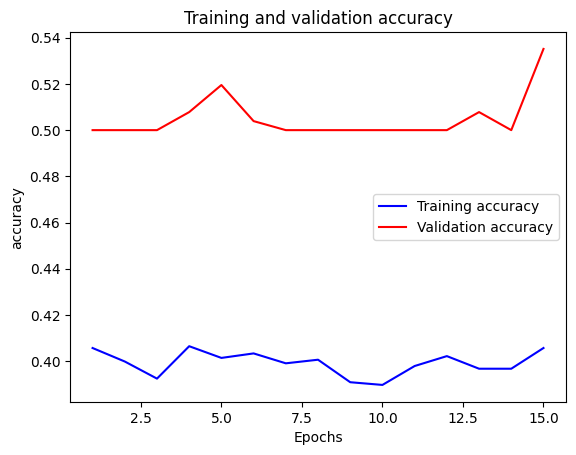

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1 , len(acc) + 1)

plt.plot(epochs , acc , 'b' , label = 'Training accuracy' )
plt.plot(epochs , val_acc, 'r' , label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

plt.legend()
plt.rc('font', size = 15)
plt.rc('figure', figsize=[10,10])
plt.show()


In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")

Saving mulher.jpeg to mulher.jpeg
Saving cavalo.jpeg to cavalo.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
[1.]
mulher.jpeg is a human
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[1.]
cavalo.jpeg is a human


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


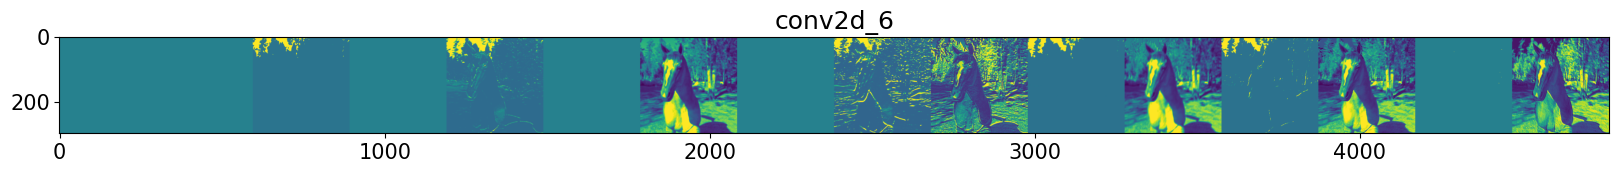

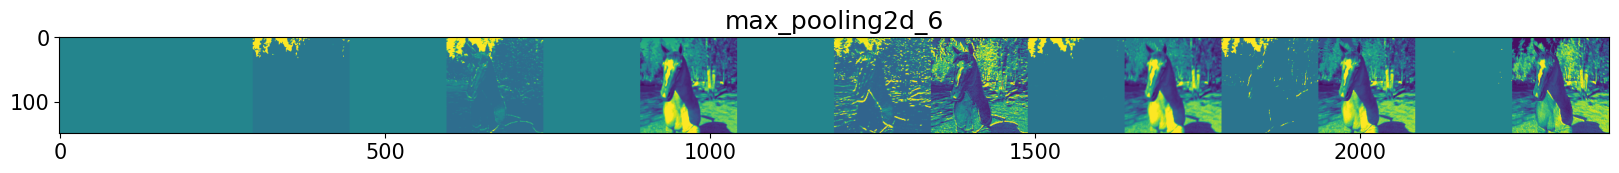

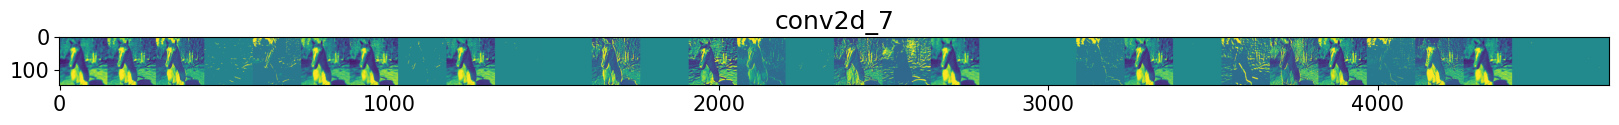

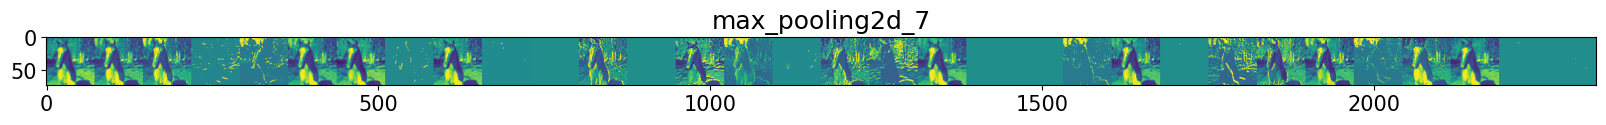

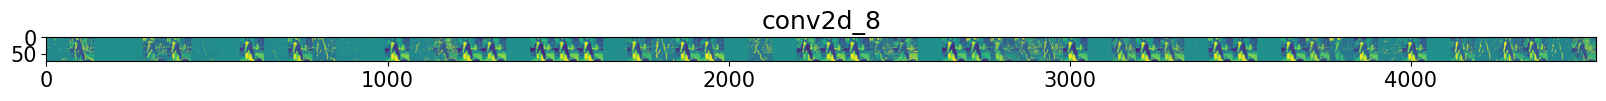

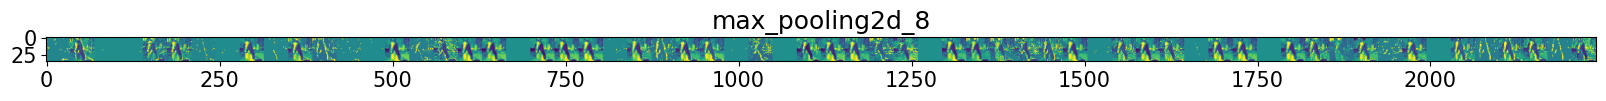

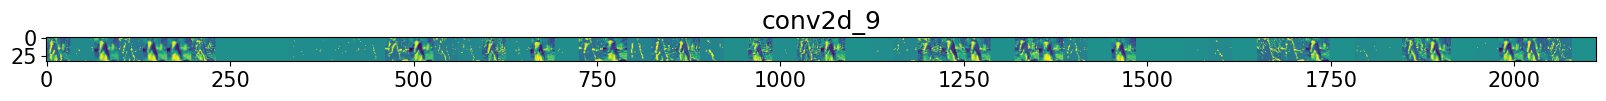

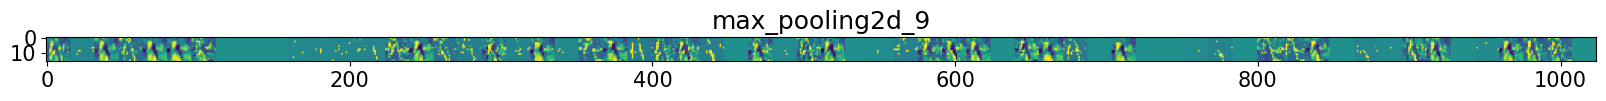

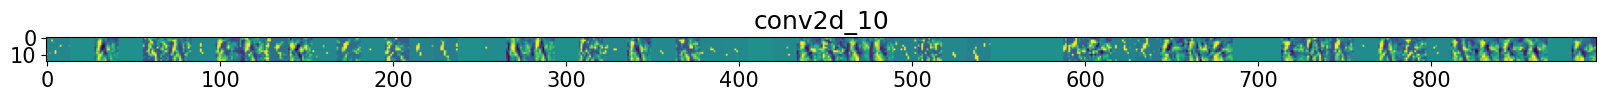

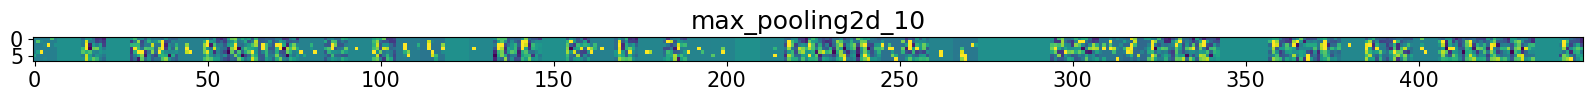

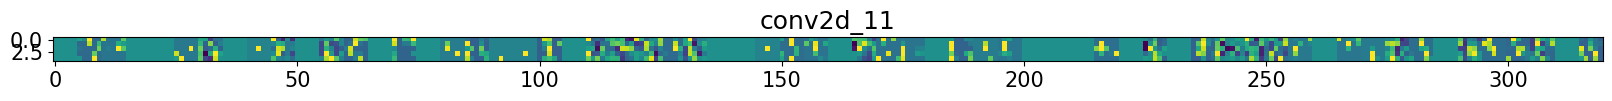

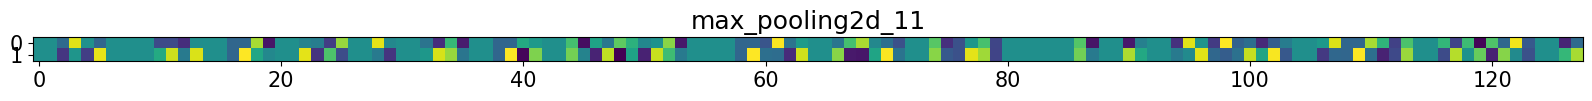

In [ ]:
# Create a new Input layer for the visualization model
img_input_viz = tf.keras.Input(shape=(300, 300, 3))

# Pass the input through the layers of the original model to get the outputs
x_viz = img_input_viz
successive_outputs = []
# Start from the second layer, as the first layer is the input layer in the visualization model
for layer in model.layers: # Start from the first layer
    x_viz = layer(x_viz)
    successive_outputs.append(x_viz)


#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = img_input_viz, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = image.load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = image.img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      std = x.std()
      if std > 0: # Avoid division by zero
        x /= std
      else:
        x = np.zeros_like(x) # Set to zero if std is zero

      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')